## This notebook demonstrates how to visualise convnet filters

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers, models, optimizers, regularizers, backend as K
from keras.preprocessing.image import ImageDataGenerator, save_img
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications.inception_v3 import InceptionV3, preprocess_input

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

sns.set(style='whitegrid', font_scale=1.25)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
N_CLASSES = 10

## Functions

In [3]:
def plot_metric_vs_epochs(data, ax=None, figsize=(16, 5), **set_kwargs):
    """
    data : dict
        A dictionary of data
    """
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()

    for data_label, data_points in data.items():
        epochs = range(1, len(data_points)+1)
        ax.plot(epochs, data_points, label=data_label)
        ax.legend()
        ax.set(**set_kwargs)

    return fig, ax


def plot_loss_acc(history, figsize=(16, 5)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    plot_metric_vs_epochs(data={k: v for (k, v) in history.history.items() if k in ['loss', 'val_loss']},
                          ax=ax[0],
                          title='Training and validation loss',
                          xlabel='Epochs', 
                          ylabel='Loss')

    plot_metric_vs_epochs(data={k: v for (k, v) in history.history.items() if k in ['categorical_accuracy', 'val_categorical_accuracy']},
                          ax=ax[1],
                          title='Training and validation accuracy',
                          xlabel='Epochs', 
                          ylabel='Accuracy')

    plt.show()
    return fig, ax


def show_image(data, width, height, figsize, ax):
    ax.imshow(data.reshape(width, height), cmap="gray", vmin=0, vmax=255)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [4]:
data_train = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv")

In [5]:
data_train.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(data_train.iloc[:, 1:], data_train["label"], test_size=.2)

In [7]:
print(f"X_train: {X_train.shape}")
print(f"X_valid: {X_valid.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_valid: {y_valid.shape}")

X_train: (48000, 784)
X_valid: (12000, 784)
y_train: (48000,)
y_valid: (12000,)


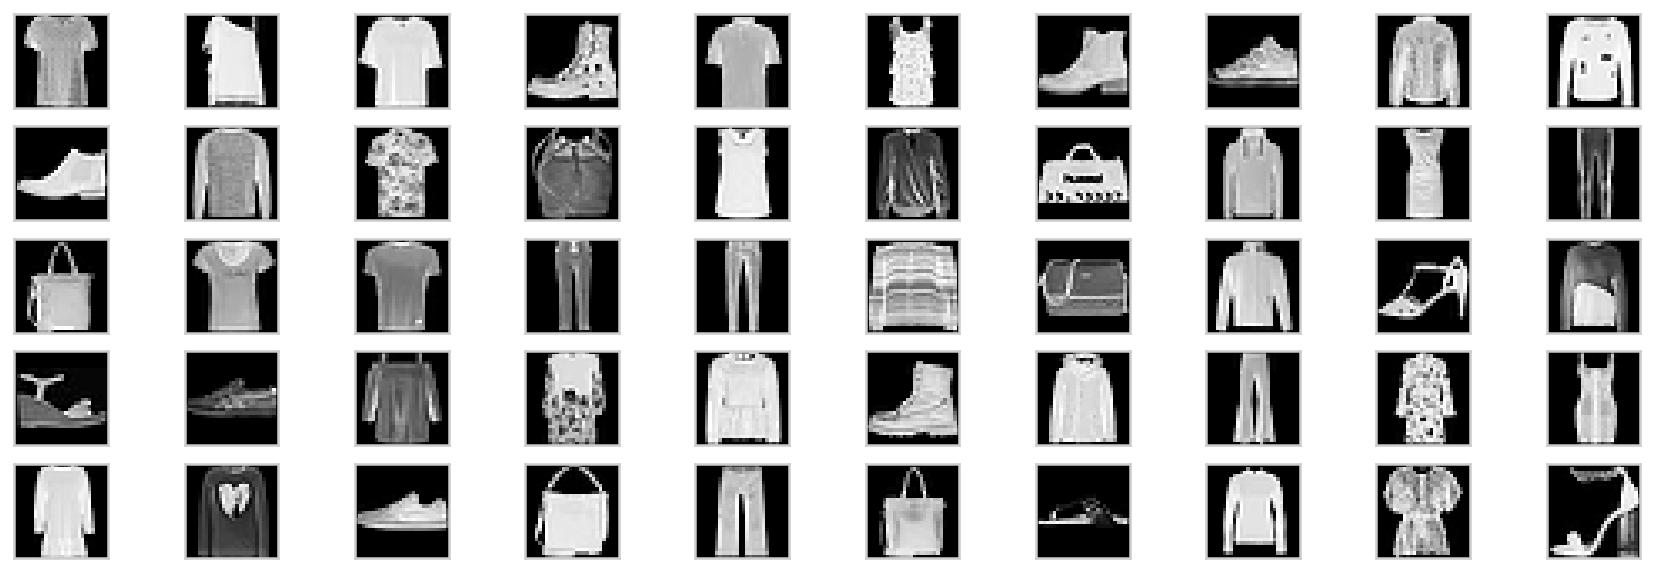

In [8]:
fig, ax = plt.subplots(5, 10, figsize=(15, 5))
plt.gray()

for i, ax_ in enumerate(ax.flatten()):
    show_image(X_train.values[i], IMAGE_WIDTH, IMAGE_HEIGHT, (4, 4), ax_)
    
plt.show()

<AxesSubplot:xlabel='class', ylabel='label'>

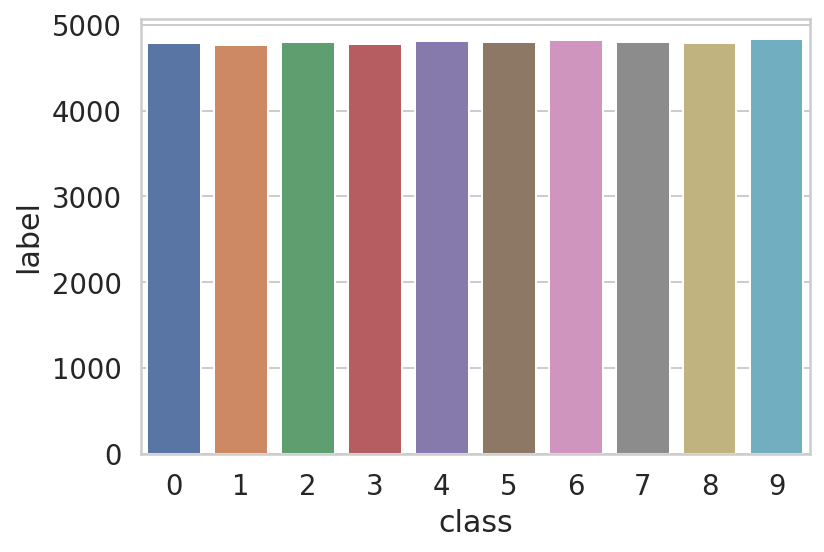

In [9]:
class_cnt = y_train.value_counts().reset_index().rename(columns={"index": "class"})
sns.barplot(x="class", y="label", data=class_cnt)

In [10]:
X_train_ = X_train.values.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS).astype('float32')
y_train_ = to_categorical(y_train, num_classes=N_CLASSES)

X_valid_ = X_valid.values.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS).astype('float32')
y_valid_ = to_categorical(y_valid, num_classes=N_CLASSES)

In [11]:
train_aug_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,
        rescale=1/255., 
        rotation_range=40, 
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        shear_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True,
        preprocessing_function=preprocess_input
)

valid_datagen = ImageDataGenerator(rescale=1/255.)  # Validation data should not be augmented!!!

train_aug_generator = train_aug_datagen.flow(X_train_, y_train_, batch_size=20)
validation_generator = valid_datagen.flow(X_valid_, y_valid_, batch_size=20)

In [12]:
# define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=10, min_lr=0.001)
early_stopper = EarlyStopping(monitor='val_categorical_accuracy', patience=5)

## Building a Convnet from scratch

In [13]:
def build_model_1(**params):
    model = models.Sequential()
    
    model.add(layers.BatchNormalization(input_shape=params['input_shape']))  # normalize each feature map at the start
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))  # 32 different 3x3 kernels -- so 32 feature maps
    model.add(layers.Dropout(0.25))  # 25% dropout of randomly selected nodes -- regularisation
    
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))  # Pool the max values over a 2x2 kernel -- downsampling
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(params["n_classes"], activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=1e-4),
                  metrics=['categorical_accuracy'])
    
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0

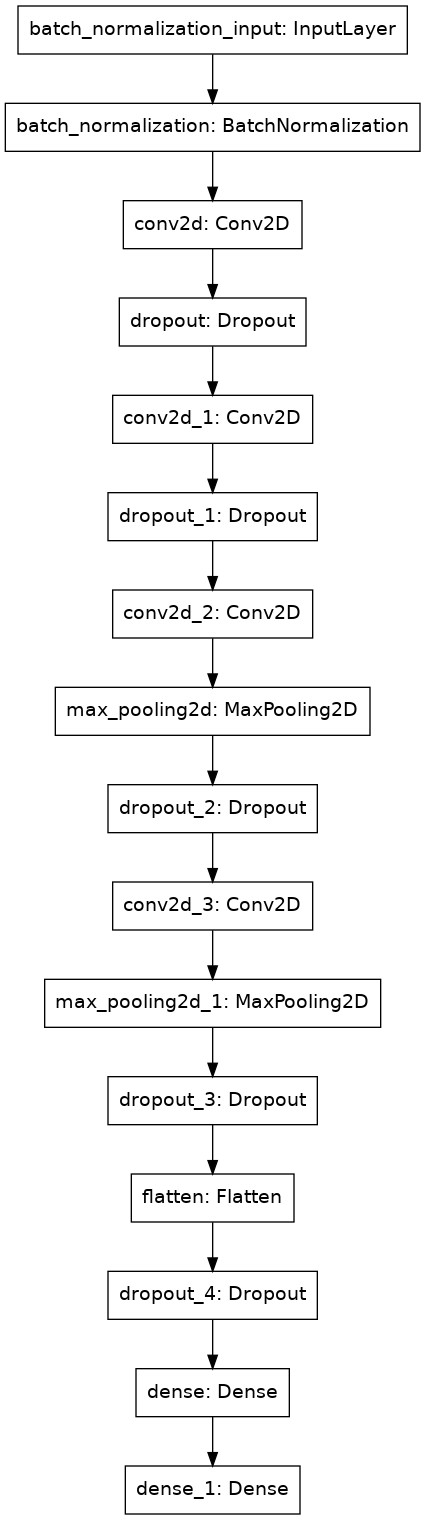

In [14]:
model_1 = build_model_1(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    n_classes=N_CLASSES
)

model_1.summary()
plot_model(model_1)

In [15]:
# `fit_generator` is equivalent to `fit` but takes in a generator instead of an array
history_model_1 = model_1.fit(
    x=train_aug_generator,
    steps_per_epoch=100, # at each epoch, number of data batch to be yielded from generator (in this case 100*20 samples will be yielded)
    epochs=30,
    validation_data=validation_generator, 
    validation_steps=50, # if a generator is specified in `validation_data`, should specify number of data batch to be yielded (in this case 50*20 samples will be yielded)
    callbacks=[reduce_lr, early_stopper]
)

Epoch 1/30
100/100 [==============================] - 3s 17ms/step - loss: 2.2759 - categorical_accuracy: 0.1178 - val_loss: 6.7868 - val_categorical_accuracy: 0.1660
Epoch 2/30
100/100 [==============================] - 1s 12ms/step - loss: 1.7658 - categorical_accuracy: 0.3750 - val_loss: 8.1521 - val_categorical_accuracy: 0.2720
Epoch 3/30
100/100 [==============================] - 1s 12ms/step - loss: 1.6821 - categorical_accuracy: 0.3766 - val_loss: 13.7389 - val_categorical_accuracy: 0.2290
Epoch 4/30
100/100 [==============================] - 1s 13ms/step - loss: 1.6100 - categorical_accuracy: 0.3935 - val_loss: 19.9138 - val_categorical_accuracy: 0.3070
Epoch 5/30
100/100 [==============================] - 1s 13ms/step - loss: 1.5209 - categorical_accuracy: 0.4313 - val_loss: 31.1258 - val_categorical_accuracy: 0.3510
Epoch 6/30
100/100 [==============================] - 1s 12ms/step - loss: 1.4936 - categorical_accuracy: 0.4508 - val_loss: 46.0541 - val_categorical_accuracy: 0

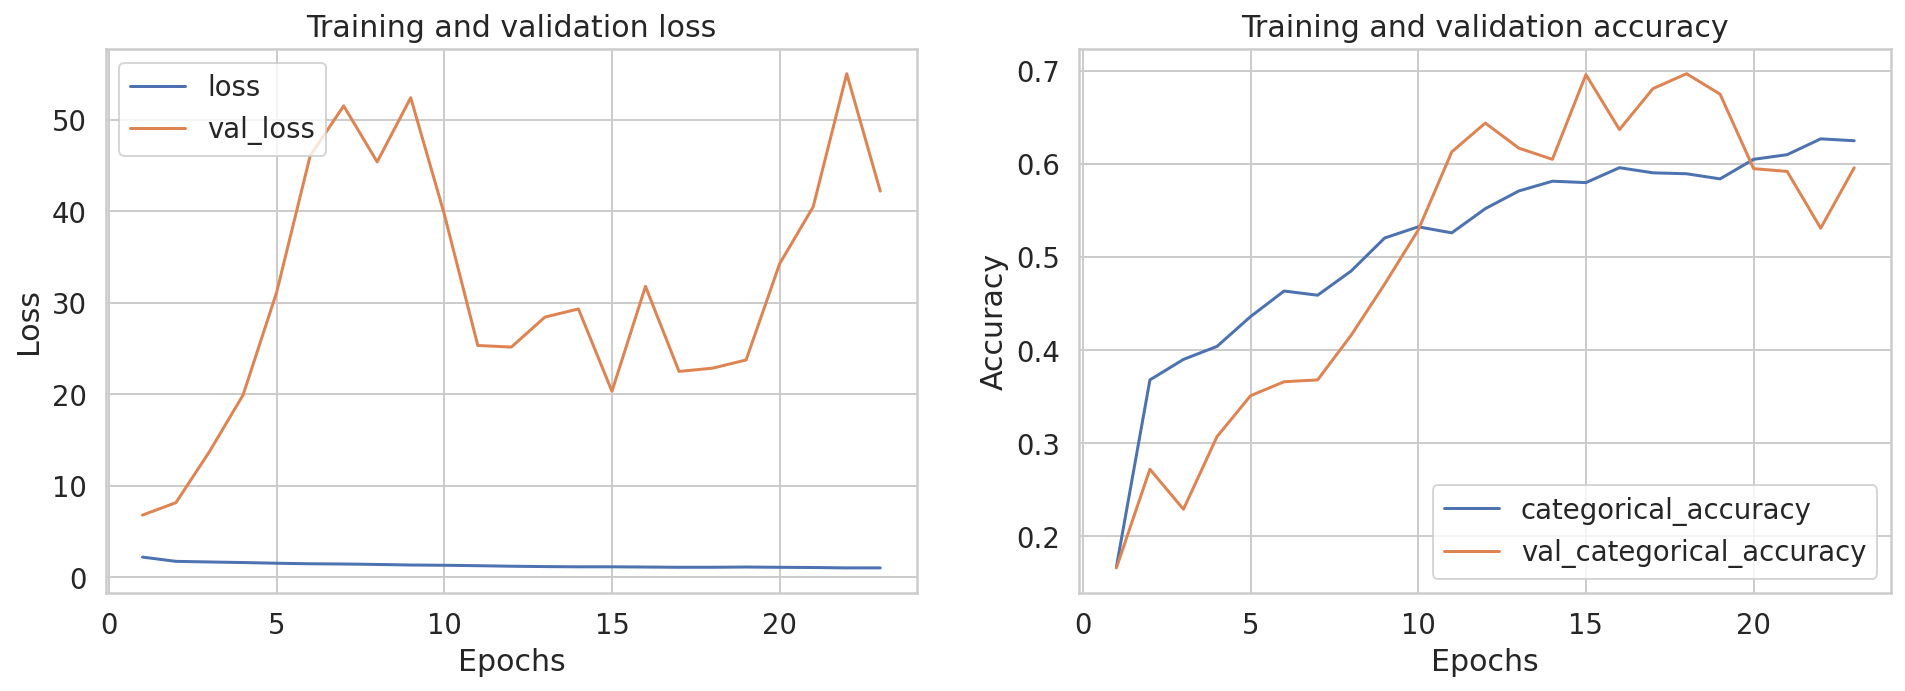

In [16]:
plot_loss_acc(history_model_1)
plt.show()

## Visualising intermediate activations

In [17]:
data_test = pd.read_csv("../input/fashionmnist/fashion-mnist_test.csv")

In [18]:
# choose an unseened picture
test_img = data_test.iloc[0, 1:]
test_img = test_img.values.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS).astype('float32')

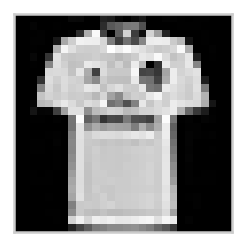

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
plt.gray()
show_image(test_img, IMAGE_WIDTH, IMAGE_HEIGHT, (2, 2), ax)
plt.show()

In [20]:
model_1.layers

In [21]:
# create a multi-output model
layer_outputs = [layer.output for layer in model_1.layers[:10]]
activation_model = models.Model(inputs=model_1.input, outputs=layer_outputs)

In [22]:
test_img_ = test_img / 225.  # input was preprocessed this way
activations = activation_model.predict(test_img_)

In [23]:
# activation the first Conv2D layer which has 28 x 28 feature map and 32 channels
activations[1].shape

(1, 28, 28, 32)

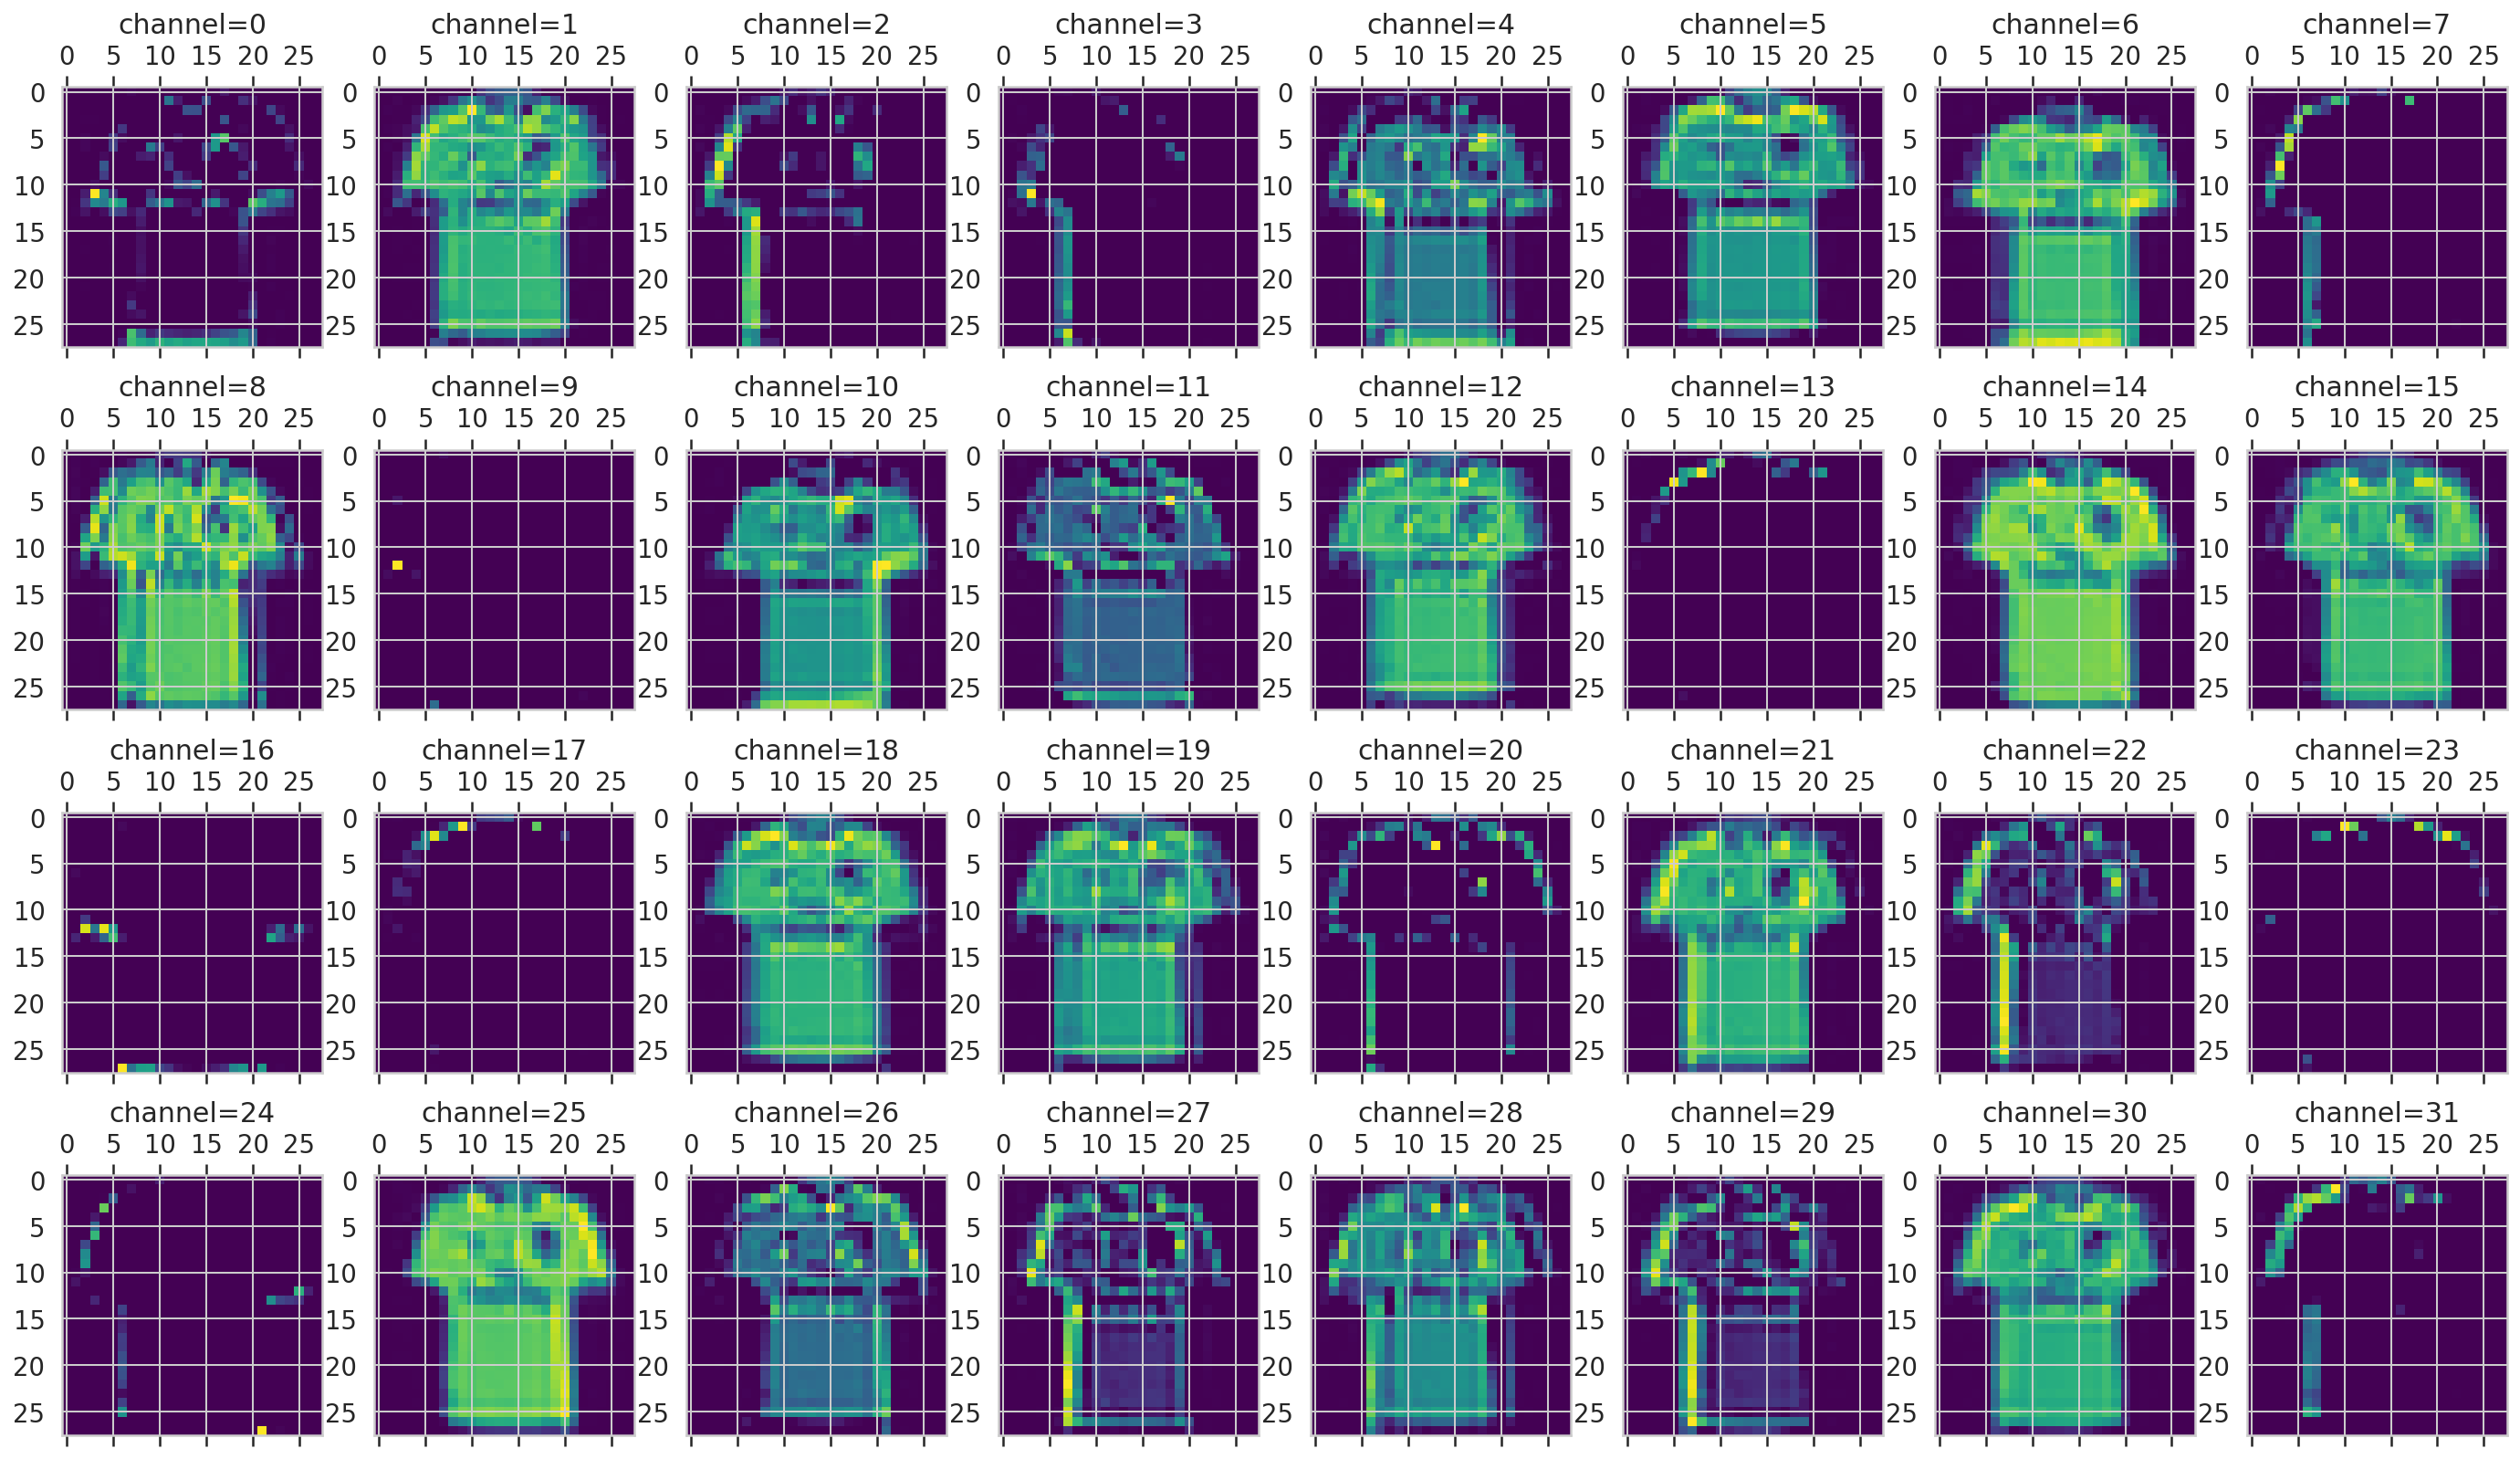

In [24]:
fig, axes = plt.subplots(4, 8, figsize=(24, 14))
axes = axes.flatten()

viz_layer = activations[1]

for channel_ in range(viz_layer.shape[3]):
    axes[channel_].matshow(viz_layer[0, :, :, channel_], cmap="viridis")
    axes[channel_].set(title=f"channel={channel_}")

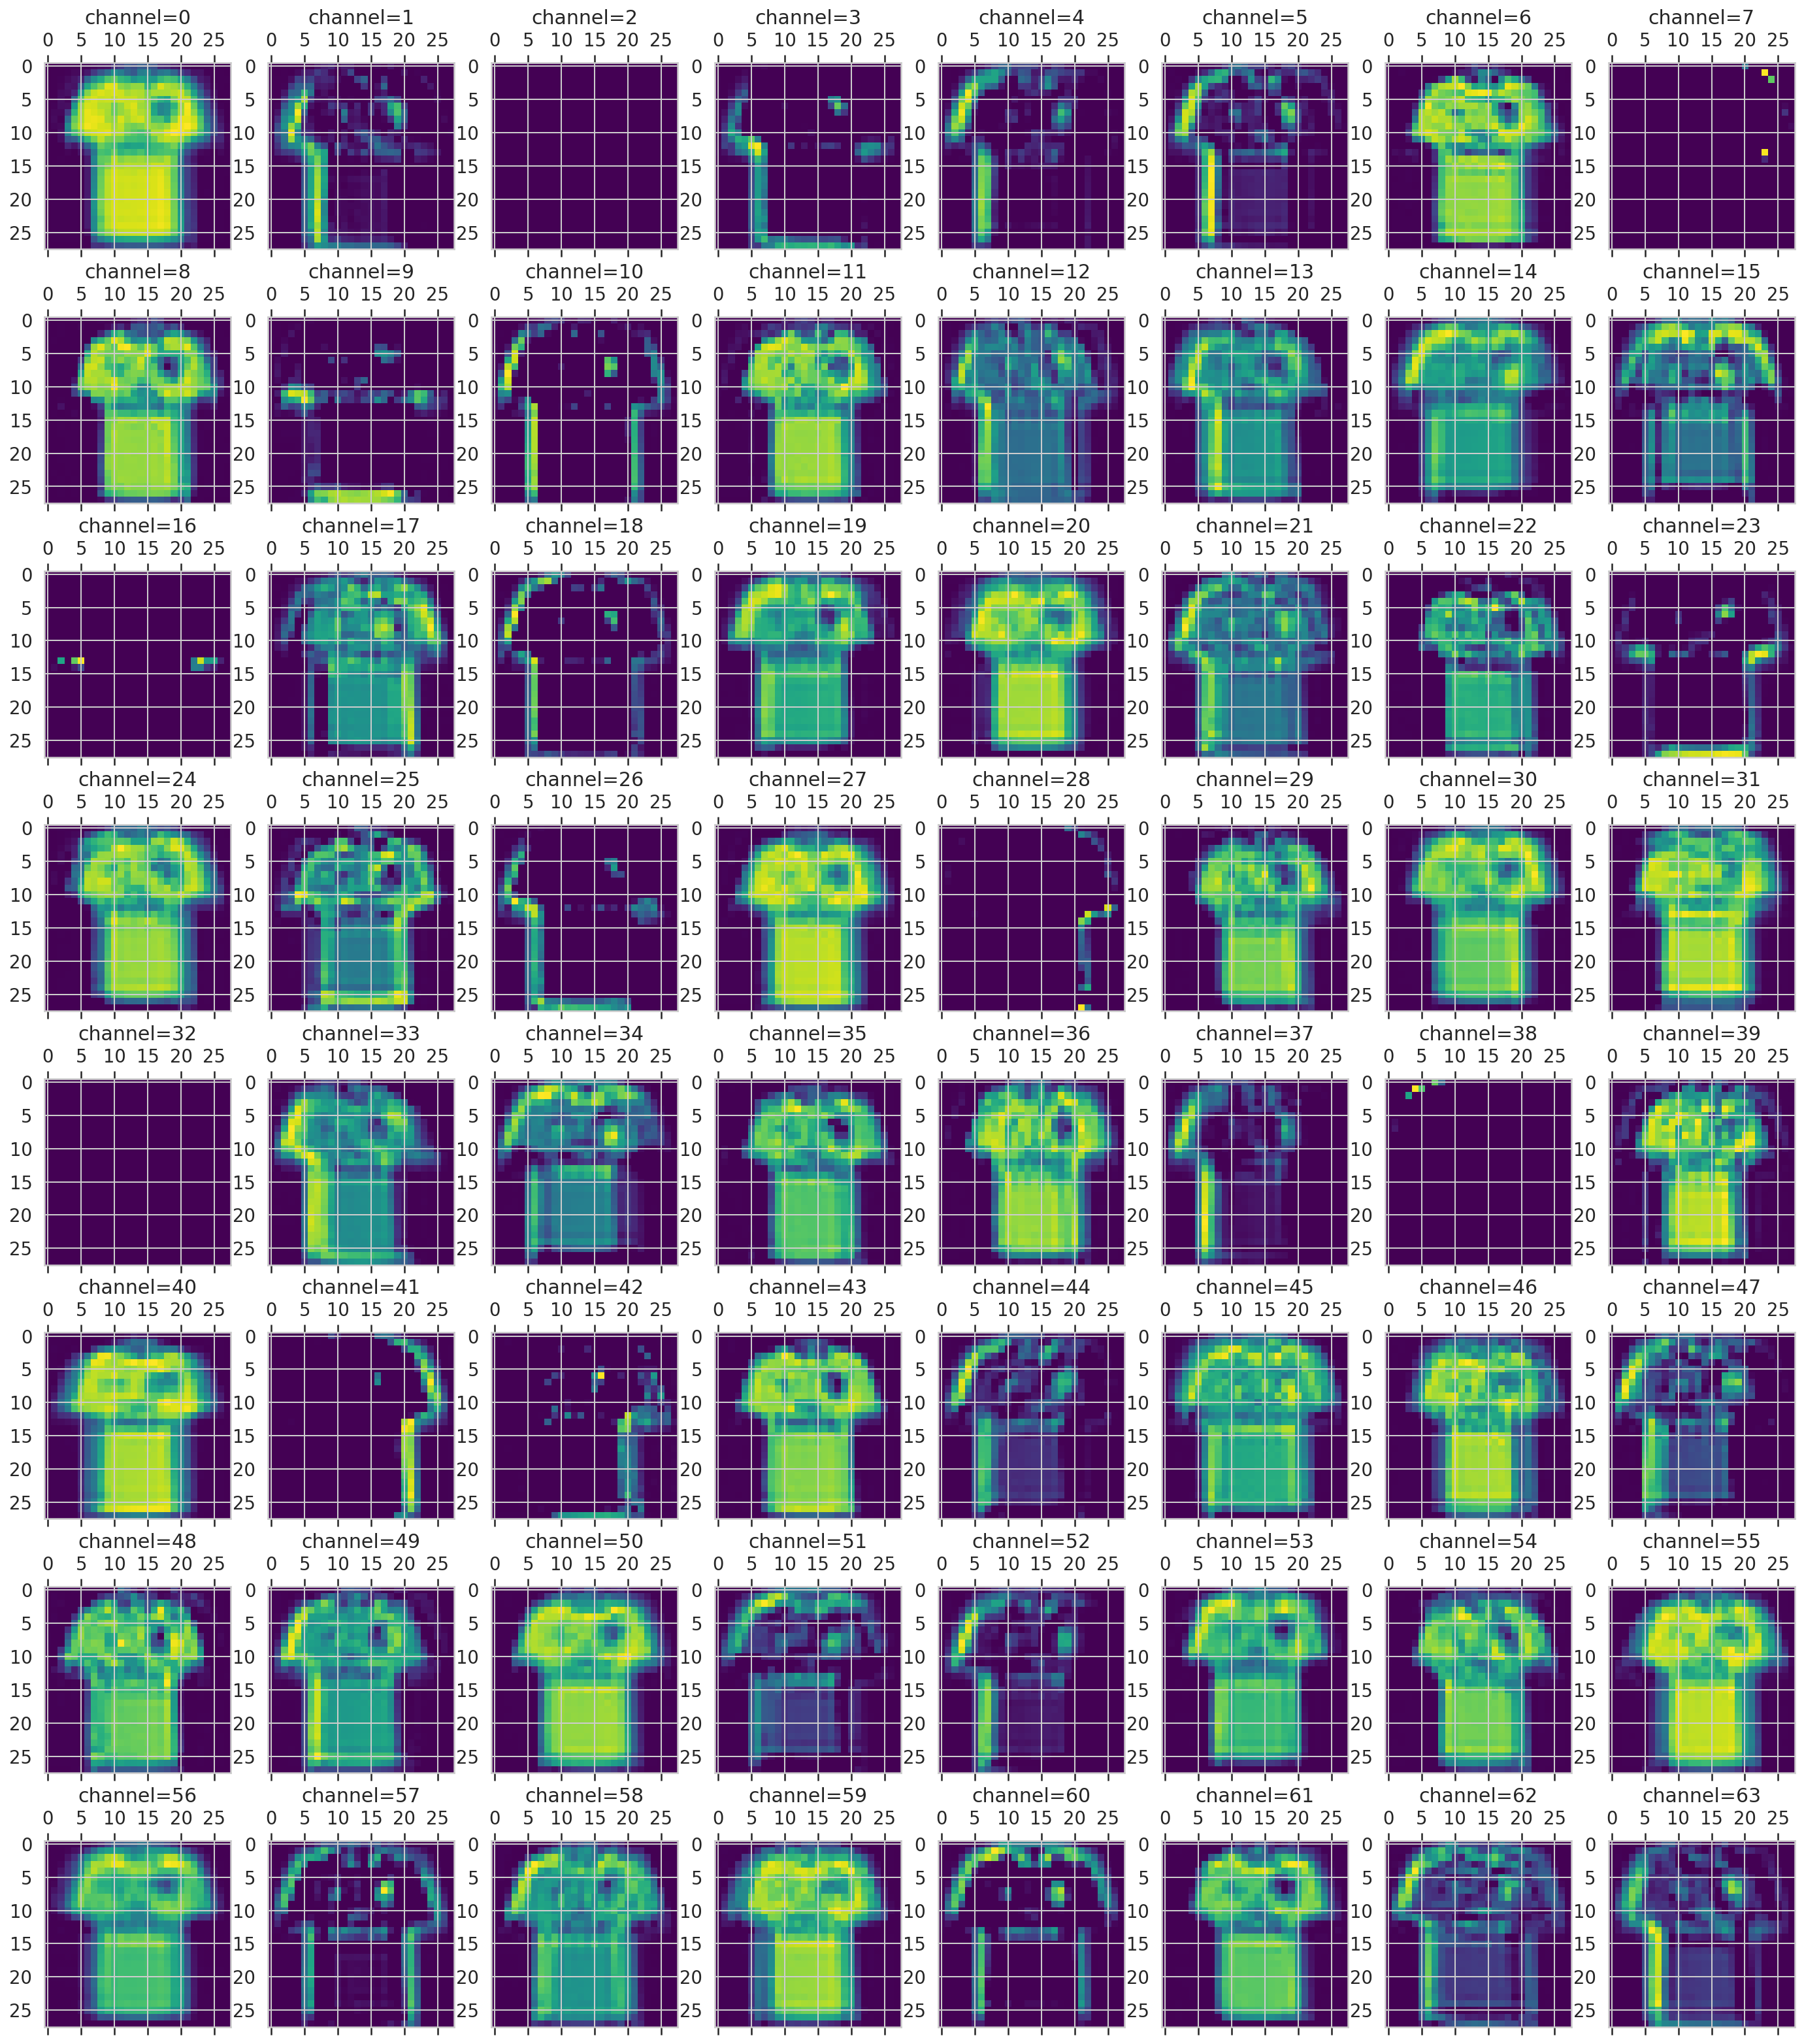

In [25]:
fig, axes = plt.subplots(8, 8, figsize=(24, 28))
axes = axes.flatten()

viz_layer = activations[3]

for channel_ in range(viz_layer.shape[3]):
    axes[channel_].matshow(viz_layer[0, :, :, channel_], cmap="viridis")
    axes[channel_].set(title=f"channel={channel_}")

## Visualising convnet filters

Display visual pattern that each filter is meant to respond to by using gradient ascent in the input space.

This is done by applying gradient descent to the value of the input image of a convnet so as to maximise the response of a specific filter, starting from a blank input image.

The resulting input image will be one that the chosen filter is maximally responsive to.

The aim is to returns a valid image tensor representing the pattern that maximises the activation of the specifed filter.

Reference: https://keras.io/examples/vision/visualizing_what_convnets_learn/

In [26]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)


@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, IMAGE_WIDTH, IMAGE_HEIGHT, 1))
    # expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 30 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    # img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [27]:
layer = model_1.get_layer(name="conv2d")
feature_extractor = models.Model(inputs=model_1.inputs, outputs=layer.output)

In [28]:
loss, img = visualize_filter(0)
save_img("0.png", img)

In [29]:
display(Image("0.png", width=100, height=100))